# Food Diversity in Major Canadian Cities

Canada has always been known for be a “melting pot” for culture. As of 2016, the population of immigrants in Canada sits at just above 7.5 million, making up almost 22% of the country’s population. With its people being so diverse, so too is its food. The following analysis uses the Foursquare Places API to find the 50 closest food venues of 26 different cities, and attempts to categorize them based on the most common types of restaurants. 

![alt text](https://images.unsplash.com/photo-1529690678884-189e81f34ef6?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80 "Logo Title Text 1")

Photo by Alice on Unsplash

## Importing Libraries

In [1367]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn.cluster import KMeans
 
print('Libraries imported.')

Libraries imported.


## Dataset 1: Immigration Data from Stats Canada
The data was gathered via the 2016 Canada Census. 'Recent' columns is the population/percentage that immigrated from 2011 to 2016.  
[Link to Dataset](https://www150.statcan.gc.ca/n1/daily-quotidien/171025/t001b-eng.htm#fn01)

In [1368]:
df_immigration = pd.read_csv('./t001b-eng.csv', header=2, index_col=False)
df_immigration = df_immigration.iloc[1:(len(df_immigration)-6), ]
df_immigration.rename(columns={ df_immigration.columns[0]: "City", df_immigration.columns[1]: "ImmigrationPop", df_immigration.columns[2]: "Distribution", df_immigration.columns[3]: "ImmigrationProportion" , df_immigration.columns[2]: "Distribution", df_immigration.columns[4]: "ImmigrationPopRecent",df_immigration.columns[5]: "DistributionRecent" , df_immigration.columns[6]: "ProportionRecent" }, inplace=True)
df_immigration.set_index('City', inplace=True)
df_immigration.head()

,ImmigrationPop,Distribution,ImmigrationProportion,ImmigrationPopRecent,DistributionRecent,ProportionRecent
City,,,,,,
Toronto,2705550.0,35.9,46.1,356930.0,29.4,6.1
Montréal,936305.0,12.4,23.4,179270.0,14.8,4.5
Vancouver,989545.0,13.1,40.8,142535.0,11.8,5.9
Calgary,404700.0,5.4,29.4,93255.0,7.7,6.8
Ottawa–Gatineau,255800.0,3.4,19.7,37890.0,3.1,2.9


In [1369]:
print("Shape of df_immigration: ", df_immigration.shape)

Shape of df_immigration:  (35, 6)


## Dataset 2: Canada Cities 
From Simplemaps.com, mostly for coordinates and population: [Link to Dataset](https://simplemaps.com/data/ca-cities)

In [1370]:
df_ll = pd.read_csv('./ca.csv', index_col=False)
df_ll = df_ll[['city', 'lat', 'lng', 'admin', 'population']]
df_ll.rename(columns={'city':'City', 'admin':'Province'}, inplace=True)
# df_ll.drop(['population'], axis=1, inplace=True)
df_ll.set_index('City', inplace=True)
df_ll.head()

,lat,lng,Province,population
City,,,,
Toronto,43.666667,-79.416667,Ontario,5213000
Montréal,45.500000,-73.583333,Québec,3678000
Vancouver,49.250000,-123.133333,British Columbia,2313328
Ottawa,45.416667,-75.700000,Ontario,1145000
Calgary,51.083333,-114.083333,Alberta,1110000


In [1371]:
#Find cities that don't match
for i in df_immigration.index:
    if i not in df_ll.index:
        print(i)

Ottawa–Gatineau
Kitchener–Cambridge–Waterloo
St. Catharines–Niagara
Oshawa 
Victoria 
Saskatoon 
St. John’s
Abbotsford–Mission
Greater Sudbury
Saguenay
Guelph
Brantford
Saint John 


In [1372]:
#Drop entries that have no location data in the simplemaps database; edit some interchangeable city names
df_immigration.rename(index={'Ottawa–Gatineau':'Ottawa',
                             'Kitchener–Cambridge–Waterloo': 'Kitchener',
                             'Abbotsford–Mission': 'Abbotsford',
                             'Greater Sudbury': 'Sudbury'
                            },inplace=True)

to_drop = []

for i in df_immigration.index:
    if i not in df_ll.index:
        to_drop.append(i)
        
df_immigration.drop(to_drop, inplace=True)
df_cities = df_ll.merge(df_immigration, on='City', how = 'right')
df_cities

,lat,lng,Province,population,ImmigrationPop,Distribution,ImmigrationProportion,ImmigrationPopRecent,DistributionRecent,ProportionRecent
City,,,,,,,,,,
Toronto,43.666667,-79.416667,Ontario,5213000,2705550.0,35.9,46.1,356930.0,29.4,6.1
Montréal,45.500000,-73.583333,Québec,3678000,936305.0,12.4,23.4,179270.0,14.8,4.5
Vancouver,49.250000,-123.133333,British Columbia,2313328,989545.0,13.1,40.8,142535.0,11.8,5.9
Ottawa,45.416667,-75.700000,Ontario,1145000,255800.0,3.4,19.7,37890.0,3.1,2.9
Calgary,51.083333,-114.083333,Alberta,1110000,404700.0,5.4,29.4,93255.0,7.7,6.8
Edmonton,53.550000,-113.500000,Alberta,1058000,308610.0,4.1,23.8,78520.0,6.5,6.1
Hamilton,43.256101,-79.857484,Ontario,721053,177075.0,2.3,24.1,17420.0,1.4,2.4
Winnipeg,49.883333,-97.166667,Manitoba,632063,181965.0,2.4,23.9,52460.0,4.3,6.9
Québec,46.800000,-71.250000,Québec,624177,44550.0,0.6,5.7,13445.0,1.1,1.7


## Dataset 3: Population by City
From Stats Canada, 2016 Census: [Link to Dataset](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=201&S=3&O=D)

In [1373]:
# df_population = pd.read_csv('population_by_city.CSV', index_col=False, encoding = "ISO-8859-1")
# df_population.set_index('Geographic name', inplace=True)
# df_population = df_population.iloc[1:len(df_population)-8, ]
# df_population = df_population[['Population, 2016']].astype(dtype={'Population, 2016': 'int32'})
# df_population.rename(index = {'Ottawa - Gatineau':'Ottawa',
#                              'Kitchener - Cambridge - Waterloo': 'Kitchener',
#                              'Abbotsford - Mission': 'Abbotsford',
#                              'Greater Sudbury': 'Sudbury'}, columns = { 'Population, 2016': 'Population'}, inplace=True)
# df_population.drop(['Ottawa - Gatineau (Quebec part)', 'Ottawa - Gatineau (Ontario part)'], inplace=True)
# df_population.index.names = ['City']
# df_population

In [1374]:
# df_cities = df_population.merge(df_cities, on='City')
# df_cities.shape

## Dataset 4: Visible Minority Count
From Stats Canada, 2016 Census: [Link to Dataset](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/dt-td/Rp-eng.cfm?TABID=1&LANG=E&A=R&APATH=3&DETAIL=0&DIM=0&FL=A&FREE=0&GC=01&GL=-1&GID=1341679&GK=1&GRP=1&O=D&PID=110692&PRID=10&PTYPE=109445&S=0&SHOWALL=0&SUB=0&Temporal=2017&THEME=124&VID=0&VNAMEE=&VNAMEF=&D1=0&D2=0&D3=0&D4=0&D5=0&D6=0)

In [1375]:
#merge the two
df_minority = pd.read_csv('visible_minorities.CSV', index_col=False)
df_minority.set_index('City', inplace=True)
df_minority

,VisibleMinorities
City,
Abbotsford,13205
Barrie,13205
Belleville,3220
Calgary,355315
Edmonton,279280
Halifax,34915
Hamilton,100175
Kelowna,11890
Kingston,9865


In [1376]:
df_cities = df_minority.merge(df_cities, on='City')
df_cities.head()

,VisibleMinorities,lat,lng,Province,population,ImmigrationPop,Distribution,ImmigrationProportion,ImmigrationPopRecent,DistributionRecent,ProportionRecent
City,,,,,,,,,,,
Abbotsford,13205,49.050000,-122.300000,British Columbia,151683,43780.0,0.6,24.8,5880.0,0.5,3.3
Barrie,13205,44.383333,-79.700000,Ontario,182041,26140.0,0.3,13.4,2040.0,0.2,1.0
Belleville,3220,44.166667,-77.383333,Ontario,43990,7365.0,0.1,7.3,550.0,0.0,0.5
Calgary,355315,51.083333,-114.083333,Alberta,1110000,404700.0,5.4,29.4,93255.0,7.7,6.8
Edmonton,279280,53.550000,-113.500000,Alberta,1058000,308610.0,4.1,23.8,78520.0,6.5,6.1


In [1377]:
df_cities['MinorityProportion'] = df_cities['VisibleMinorities']/df_cities['population'] * 100
df_cities = df_cities[~df_cities.index.duplicated()]
df_cities

,VisibleMinorities,lat,lng,Province,population,ImmigrationPop,Distribution,ImmigrationProportion,ImmigrationPopRecent,DistributionRecent,ProportionRecent,MinorityProportion
City,,,,,,,,,,,,
Abbotsford,13205,49.050000,-122.300000,British Columbia,151683,43780.0,0.6,24.8,5880.0,0.5,3.3,8.705656
Barrie,13205,44.383333,-79.700000,Ontario,182041,26140.0,0.3,13.4,2040.0,0.2,1.0,7.253860
Belleville,3220,44.166667,-77.383333,Ontario,43990,7365.0,0.1,7.3,550.0,0.0,0.5,7.319845
Calgary,355315,51.083333,-114.083333,Alberta,1110000,404700.0,5.4,29.4,93255.0,7.7,6.8,32.010360
Edmonton,279280,53.550000,-113.500000,Alberta,1058000,308610.0,4.1,23.8,78520.0,6.5,6.1,26.396975
Halifax,34915,44.650000,-63.600000,Nova Scotia,359111,37210.0,0.5,9.4,9420.0,0.8,2.4,9.722621
Hamilton,100175,43.256101,-79.857484,Ontario,721053,177075.0,2.3,24.1,17420.0,1.4,2.4,13.892876
Kelowna,11890,49.900000,-119.483333,British Columbia,125109,26455.0,0.4,13.9,2995.0,0.2,1.6,9.503713
Kingston,9865,44.300000,-76.566667,Ontario,114195,18400.0,0.2,11.8,1725.0,0.1,1.1,8.638732


## Dataset 5: Median Household Income data
The data was gathered via the 2016 Canada Census. 
[Link to Dataset](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/inc-rev/Table.cfm?Lang=Eng&T=102&PR=0&D1=1&RPP=25&SR=1&S=108&O=D)

In [1378]:
df_income = pd.read_csv('./income.csv', index_col=False, encoding = "ISO-8859-1")
df_income.head(10)

,Geographic code,Geographic name,Geographic type,Province or territory,Global non-response rate,Data quality flag,Household type,"Number of households, 2006","Number of households, 2016","Median household total income (2015 constant dollars), 2005","Median household total income (2015 constant dollars), 2015","Median household total income (2015 constant dollars), % change","Median household after-tax income (2015 constant dollars), 2005","Median household after-tax income (2015 constant dollars), 2015","Median household after-tax income (2015 constant dollars), % change"
0,01,Canada,NaN,NaN,4.0,20000.0,Total  Household type including census family...,12437470.0,14072080.0,63457.0,70336.0,10.8,55118.0,61348.0,11.3
1,725,Saskatoon,CMA,Saskatchewan,4.5,0.0,Total  Household type including census family...,95735.0,115280.0,60586.0,82999.0,37.0,52624.0,71621.0,36.1
2,705,Regina,CMA,Saskatchewan,3.9,0.0,Total  Household type including census family...,80640.0,94955.0,65897.0,84447.0,28.1,56444.0,72372.0,28.2
3,001,St. John's,CMA,Newfoundland and Labrador,3.5,0.0,Total  Household type including census family...,70660.0,85015.0,62554.0,79750.0,27.5,53516.0,68121.0,27.3
4,835,Edmonton,CMA,Alberta,4.4,0.0,Total  Household type including census family...,405275.0,502145.0,74615.0,94447.0,26.6,64418.0,80578.0,25.1
5,825,Calgary,CMA,Alberta,3.8,0.0,Total  Household type including census family...,415605.0,519695.0,81138.0,99583.0,22.7,69442.0,84773.0,22.1
6,810,Lethbridge,CMA,Alberta,4.8,0.0,Total  Household type including census family...,37300.0,45695.0,62610.0,75452.0,20.5,55568.0,66779.0,20.2
7,915,Kelowna,CMA,British Columbia,4.6,0.0,Total  Household type including census family...,67000.0,81380.0,59517.0,71127.0,19.5,53119.0,62366.0,17.4
8,602,Winnipeg,CMA,Manitoba,3.3,0.0,Total  Household type including census family...,281760.0,306550.0,60719.0,70795.0,16.6,52123.0,60846.0,16.7
9,932,Abbotsford - Mission,CMA,British Columbia,4.3,0.0,Total  Household type including census family...,55950.0,62630.0,64521.0,73598.0,14.1,57260.0,64890.0,13.3


In [1379]:
df_income_col = df_income[[df_income.columns[1], df_income.columns[10]]]
df_income_col = df_income_col.iloc[0:38,]
df_income_col.rename(columns={df_income.columns[1]:'City', df_income.columns[10]:'MedianIncome'}, inplace=True)
df_income_col.set_index('City', inplace=True)
df_income_col.drop('Canada', inplace=True)
df_income_col

,MedianIncome
City,
Saskatoon,82999.0
Regina,84447.0
St. John's,79750.0
Edmonton,94447.0
Calgary,99583.0
Lethbridge,75452.0
Kelowna,71127.0
Winnipeg,70795.0
Abbotsford - Mission,73598.0


In [1380]:
for i in df_income_col.index:
    if i not in df_cities.index:
        print(i)

Saskatoon
St. John's
Abbotsford - Mission
Greater Sudbury
Saint John
Victoria
Saguenay
Ottawa - Gatineau
Ottawa - Gatineau (Quebec part)
Ottawa - Gatineau (Ontario part)
Brantford
Guelph
Kitchener - Cambridge - Waterloo
Oshawa
St. Catharines - Niagara


In [1381]:
df_income_col.drop(['Ottawa - Gatineau (Quebec part)', 'Ottawa - Gatineau (Ontario part)'], inplace=True)
df_income_col.rename(index = {'Ottawa - Gatineau':'Ottawa',
                             'Kitchener - Cambridge - Waterloo': 'Kitchener',
                             'Abbotsford - Mission': 'Abbotsford',
                             'Greater Sudbury': 'Sudbury'}, inplace=True)
df_income_col
df_cities = df_income_col.merge(df_cities, on='City', how = 'right')


In [1382]:
df_cities.head()

,MedianIncome,VisibleMinorities,lat,lng,Province,population,ImmigrationPop,Distribution,ImmigrationProportion,ImmigrationPopRecent,DistributionRecent,ProportionRecent,MinorityProportion
City,,,,,,,,,,,,,
Regina,84447.0,30965,50.450000,-104.616667,Saskatchewan,176183,36910.0,0.5,15.9,16195.0,1.3,7.0,17.575475
Edmonton,94447.0,279280,53.550000,-113.500000,Alberta,1058000,308610.0,4.1,23.8,78520.0,6.5,6.1,26.396975
Calgary,99583.0,355315,51.083333,-114.083333,Alberta,1110000,404700.0,5.4,29.4,93255.0,7.7,6.8,32.010360
Lethbridge,75452.0,9440,49.700000,-112.833333,Alberta,70617,15365.0,0.2,13.5,3405.0,0.3,3.0,13.367886
Kelowna,71127.0,11890,49.900000,-119.483333,British Columbia,125109,26455.0,0.4,13.9,2995.0,0.2,1.6,9.503713


In [1383]:
df_cities.to_csv('city_info.csv')

## Visualizations and EDA
### Radiuses proportionate to city population

In [1384]:
map_can = folium.Map(location=[56.1304, -106.3468], zoom_start=3)

# add markers to map
def draw_map(df, map_out, marker_scale, to_scale):
    
    for lat, lng, city, r in zip(df['lat'], df['lng'], df.index, df[to_scale]):
        label = city
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=round(r/marker_scale),
            popup=label,
            color='#e07b48',
            fill=True,
            fill_color='#e07b48',
            fill_opacity=0.7,
            parse_html=False).add_to(map_out)
        
    return map_out
    
map_can = draw_map(df_cities, map_can, 54111, 'ImmigrationPop')
map_can

In [1385]:
map_can.save('popsizes.html')

### Radiuses proportionate to Recent Immigration population

In [1386]:
map_can = folium.Map(location=[56.1304, -106.3468], zoom_start=3)
map_can = draw_map(df_cities, map_can, 356930/50, 'ImmigrationPopRecent')
map_can

In [1387]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')

<Figure size 800x960 with 0 Axes>

<Figure size 800x960 with 0 Axes>

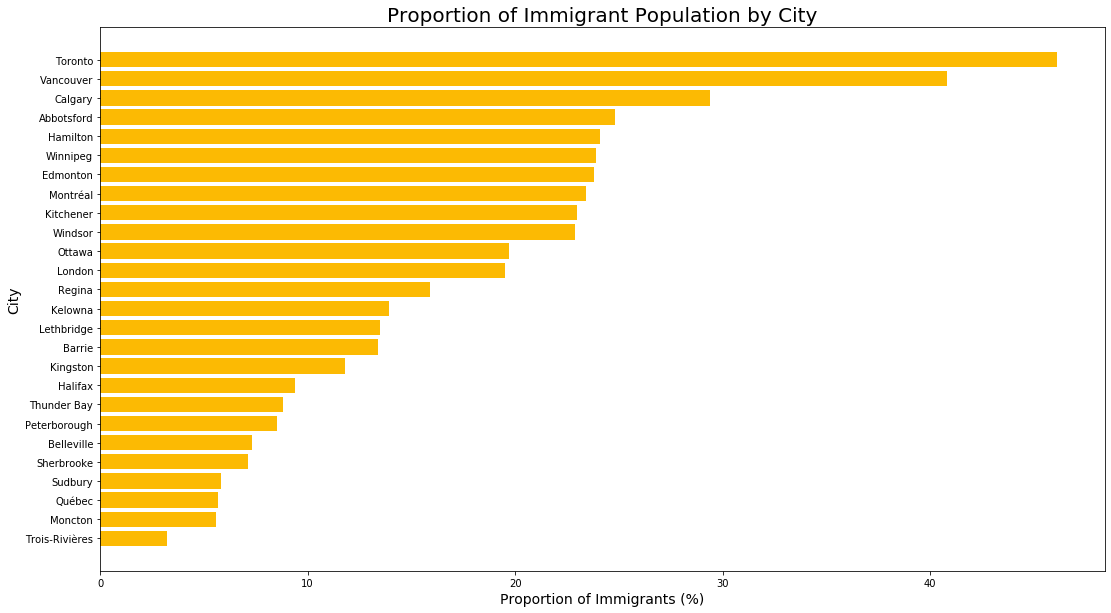

In [1388]:

plt.subplots(figsize=(18,10)) # set the size that you'd like (width, height)d
df_cities_sorted = df_cities.sort_values(by='ImmigrationProportion')
bar_cities = plt.barh(df_cities_sorted.index, df_cities_sorted['ImmigrationProportion'], color='#fcba03')
bar_cities = plt.xlabel('Proportion of Immigrants (%)', fontsize=14)
bar_cities = plt.ylabel('City' , fontsize=14)
bar_cities = plt.title('Proportion of Immigrant Population by City', fontsize=20)

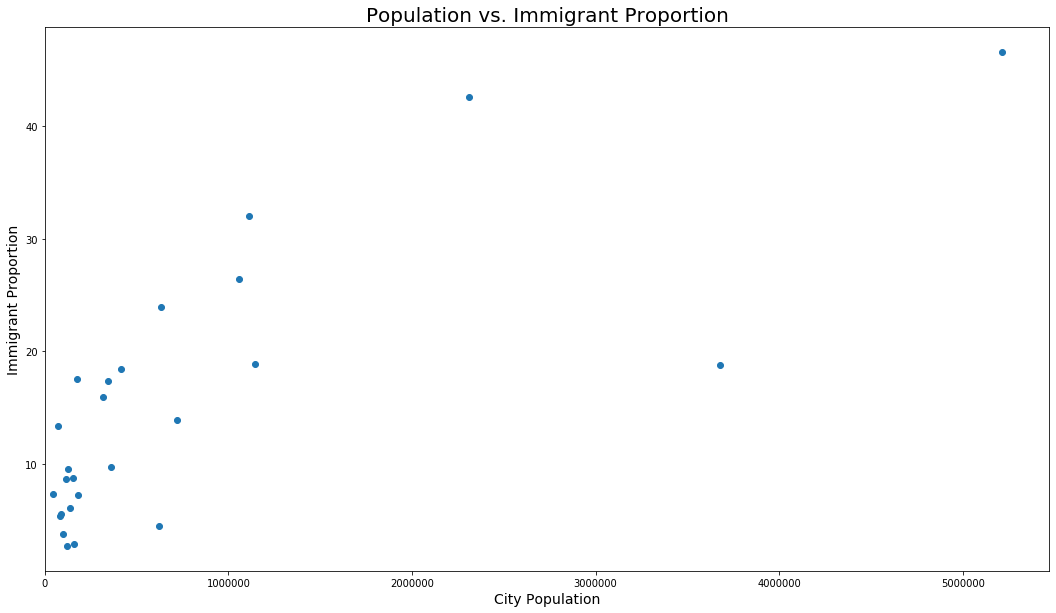

In [1389]:
from numpy.polynomial.polynomial import polyfit

plt.subplots(figsize=(18,10)) # set the size that you'd like (width, height)d
# df_cities_sorted = df_cities.sort_values(by='MinorityProportion')
bar_cities = plt.scatter(df_cities['population'], df_cities['MinorityProportion'])
bar_cities = plt.xlabel('City Population', fontsize=14)
bar_cities = plt.ylabel('Immigrant Proportion' , fontsize=14)
bar_cities = plt.title('Population vs. Immigrant Proportion', fontsize=20)
plt.xlim(left=0)
plt.show()

## Using the Foursquare Places API (Explore endpoint)

In [1390]:
CLIENT_ID = 'VYQCGHFSWNQNGLTC3LDEZU0VVJVLHFTZUI1UBOEVV4YXDWA3' # your Foursquare ID
CLIENT_SECRET = 'KWA1KOGRNUDHHDLYK13E1RKMR0Z15GRJIJHRD5Q2LEHTFTVQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VYQCGHFSWNQNGLTC3LDEZU0VVJVLHFTZUI1UBOEVV4YXDWA3
CLIENT_SECRET:KWA1KOGRNUDHHDLYK13E1RKMR0Z15GRJIJHRD5Q2LEHTFTVQ


In [1391]:

def getNearbyVenues(cities, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(cities, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section=food&sortByDistance=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    return(nearby_venues)

In [829]:
limit = 100
rad = 30000
can_venues = getNearbyVenues(cities=df_cities.index,
                                   latitudes=df_cities['lat'],
                                   longitudes=df_cities['lng'],
                                   radius=rad, 
                                   LIMIT=50
                                  )

Abbotsford
Barrie
Belleville
Calgary
Edmonton
Halifax
Hamilton
Kelowna
Kingston
Kitchener
Lethbridge
London
Moncton
Montréal
Ottawa
Peterborough
Québec
Regina
Sherbrooke
Sudbury
Thunder Bay
Toronto
Trois-Rivières
Vancouver
Windsor
Winnipeg


In [1392]:
can_venues.columns = ['City', 'CityLat', 'CityLong', 'VenueName', 'VenueID', 'lat', 'lng', 'Category']
can_venues = can_venues[can_venues.Category != 'Restaurant']
can_venues = can_venues[can_venues.Category != 'Café']
can_venues.head()

,City,CityLat,CityLong,VenueName,VenueID,lat,lng,Category
0,Abbotsford,49.05,-122.3,Nikko Sushi,4d13ae132b1fa35dc2aa4ab1,49.049321,-122.300566,Sushi Restaurant
1,Abbotsford,49.05,-122.3,De Dutch Pannekoek House,4aa7e00af964a520c84d20e3,49.049329,-122.301176,Breakfast Spot
2,Abbotsford,49.05,-122.3,White Spot Abbotsford,4b7b7e2cf964a52068652fe3,49.050577,-122.303928,Breakfast Spot
3,Abbotsford,49.05,-122.3,Subway,4bcf71d541b9ef3bf070f8e5,49.048912,-122.292903,Sandwich Place
4,Abbotsford,49.05,-122.3,Donairo's,4c7c084a3badb1f7eaa55654,49.046441,-122.293829,Middle Eastern Restaurant


In [1640]:
can_venues.to_csv(r'./foodvenues', index=False)

In [1641]:
can_venues.groupby('City').count()

,CityLat,CityLong,VenueName,VenueID,lat,lng,Category
City,,,,,,,
Abbotsford,46,46,46,46,46,46,46
Barrie,45,45,45,45,45,45,45
Belleville,43,43,43,43,43,43,43
Calgary,44,44,44,44,44,44,44
Edmonton,39,39,39,39,39,39,39
Halifax,43,43,43,43,43,43,43
Hamilton,39,39,39,39,39,39,39
Kelowna,42,42,42,42,42,42,42
Kingston,42,42,42,42,42,42,42


In [1642]:
can_venues.groupby('Category').count().sort_values(ascending=False, by='City').head()

,City,CityLat,CityLong,VenueName,VenueID,lat,lng
Category,,,,,,,
Pizza Place,81,81,81,81,81,81,81
Sandwich Place,78,78,78,78,78,78,78
Fast Food Restaurant,72,72,72,72,72,72,72
Italian Restaurant,61,61,61,61,61,61,61
Breakfast Spot,59,59,59,59,59,59,59


In [1643]:
canada_onehot = pd.get_dummies(can_venues[['Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
canada_onehot['City'] = can_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [canada_onehot.columns[-1]] + list(canada_onehot.columns[:-1])
canada_onehot = canada_onehot[fixed_columns]

canada_onehot.head()

,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pizza Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Romanian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Abbotsford,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Abbotsford,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbotsford,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abbotsford,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Abbotsford,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1644]:
canada_onehot.shape

(1065, 76)

In [1645]:
canvenues_grouped = canada_onehot.groupby('City').mean().reset_index()
canvenues_grouped.head()

,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pizza Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Romanian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Abbotsford,0.065217,0.0,0.000000,0.000000,0.0,0.021739,0.0,0.0,0.000000,0.086957,0.000000,0.065217,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.152174,0.0,0.0,0.0,0.0,0.000000,0.0,0.021739,0.0,0.021739,0.0,0.021739,0.0,0.043478,0.021739,0.000000,0.0,0.0,0.000000,0.021739,0.021739,0.0,0.021739,0.000000,0.065217,0.0,0.0,0.0,0.0,0.0,0.152174,0.000000,0.000000,0.0,0.0,0.0,0.021739,0.108696,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.021739,0.021739
1,Barrie,0.044444,0.0,0.022222,0.022222,0.0,0.133333,0.0,0.0,0.000000,0.044444,0.022222,0.044444,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,0.022222,0.0,0.000000,0.0,0.000000,0.0,0.044444,0.000000,0.000000,0.0,0.0,0.000000,0.044444,0.000000,0.0,0.000000,0.000000,0.133333,0.0,0.0,0.0,0.0,0.0,0.044444,0.000000,0.022222,0.0,0.0,0.0,0.022222,0.022222,0.0,0.0,0.0,0.088889,0.0,0.000000,0.0,0.022222,0.044444,0.000000
2,Belleville,0.000000,0.0,0.000000,0.000000,0.0,0.023256,0.0,0.0,0.000000,0.023256,0.000000,0.046512,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.0,0.0,0.000000,0.046512,0.0,0.000000,0.0,0.0,0.232558,0.0,0.0,0.0,0.0,0.023256,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.069767,0.023256,0.023256,0.0,0.0,0.000000,0.023256,0.000000,0.0,0.000000,0.000000,0.116279,0.0,0.0,0.0,0.0,0.0,0.186047,0.000000,0.023256,0.0,0.0,0.0,0.046512,0.023256,0.0,0.0,0.0,0.046512,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,Calgary,0.045455,0.0,0.000000,0.068182,0.0,0.022727,0.0,0.0,0.022727,0.068182,0.000000,0.068182,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.022727,0.045455,0.0,0.000000,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.022727,0.0,0.068182,0.0,0.000000,0.0,0.000000,0.0,0.090909,0.045455,0.022727,0.0,0.0,0.022727,0.000000,0.022727,0.0,0.000000,0.045455,0.022727,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.068182,0.022727,0.0,0.0,0.0,0.022727,0.0,0.000000,0.0,0.000000,0.113636,0.000000
4,Edmonton,0.025641,0.0,0.051282,0.025641,0.0,0.051282,0.0,0.0,0.000000,0.051282,0.000000,0.025641,0.0,0.0,0.0,0.0,0.102564,0.0,0.0,0.0,0.0,0.000000,0.025641,0.0,0.025641,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.051282,0.0,0.025641,0.0,0.000000,0.0,0.025641,0.0,0.128205,0.051282,0.000000,0.0,0.0,0.025641,0.025641,0.000000,0.0,0.000000,0.000000,0.102564,0.0,0.0,0.0,0.0,0.0,0.000000,0.025641,0.000000,0.0,0.0,0.0,0.051282,0.000000,0.0,0.0,0.0,0.025641,0.0,0.025641,0.0,0.025641,0.025641,0.000000


In [1646]:
canvenues_grouped.shape

(26, 76)

In [1647]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [1648]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = canvenues_grouped['City']

for ind in np.arange(canvenues_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(canvenues_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted = city_venues_sorted.set_index('City')

In [1649]:
city_venues_sorted.to_csv('./venues_rankings.csv')

In [1650]:
# add clustering labels
canvenues_grouped.insert(0, 'ClusterLabels', kmeans.labels_)

# canada_merged = df_cities

# # merge venue data with coordinates, income and immigration for each city
# # canada_merged = canada_merged.join(canvenues_grouped.set_index('City'), on='City')
# # canada_merged = canada_merged.join(df_income_col, on='City')

# canada_merged.drop(['Distribution', 'DistributionRecent', 'Province', 'population', 'ImmigrationPopRecent', 'VisibleMinorities', 'ImmigrationPop', 'ProportionRecent'], axis=1, inplace=True, )
# canada_merged.head()

In [1651]:
canvenues_grouped.set_index('City').head()

,ClusterLabels,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pizza Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Romanian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abbotsford,0,0.065217,0.0,0.000000,0.000000,0.0,0.021739,0.0,0.0,0.000000,0.086957,0.000000,0.065217,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.152174,0.0,0.0,0.0,0.0,0.000000,0.0,0.021739,0.0,0.021739,0.0,0.021739,0.0,0.043478,0.021739,0.000000,0.0,0.0,0.000000,0.021739,0.021739,0.0,0.021739,0.000000,0.065217,0.0,0.0,0.0,0.0,0.0,0.152174,0.000000,0.000000,0.0,0.0,0.0,0.021739,0.108696,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.021739,0.021739
Barrie,4,0.044444,0.0,0.022222,0.022222,0.0,0.133333,0.0,0.0,0.000000,0.044444,0.022222,0.044444,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,0.022222,0.0,0.000000,0.0,0.000000,0.0,0.044444,0.000000,0.000000,0.0,0.0,0.000000,0.044444,0.000000,0.0,0.000000,0.000000,0.133333,0.0,0.0,0.0,0.0,0.0,0.044444,0.000000,0.022222,0.0,0.0,0.0,0.022222,0.022222,0.0,0.0,0.0,0.088889,0.0,0.000000,0.0,0.022222,0.044444,0.000000
Belleville,0,0.000000,0.0,0.000000,0.000000,0.0,0.023256,0.0,0.0,0.000000,0.023256,0.000000,0.046512,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.0,0.0,0.000000,0.046512,0.0,0.000000,0.0,0.0,0.232558,0.0,0.0,0.0,0.0,0.023256,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.069767,0.023256,0.023256,0.0,0.0,0.000000,0.023256,0.000000,0.0,0.000000,0.000000,0.116279,0.0,0.0,0.0,0.0,0.0,0.186047,0.000000,0.023256,0.0,0.0,0.0,0.046512,0.023256,0.0,0.0,0.0,0.046512,0.0,0.000000,0.0,0.000000,0.000000,0.000000
Calgary,2,0.045455,0.0,0.000000,0.068182,0.0,0.022727,0.0,0.0,0.022727,0.068182,0.000000,0.068182,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.022727,0.045455,0.0,0.000000,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.022727,0.0,0.068182,0.0,0.000000,0.0,0.000000,0.0,0.090909,0.045455,0.022727,0.0,0.0,0.022727,0.000000,0.022727,0.0,0.000000,0.045455,0.022727,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.068182,0.022727,0.0,0.0,0.0,0.022727,0.0,0.000000,0.0,0.000000,0.113636,0.000000
Edmonton,2,0.025641,0.0,0.051282,0.025641,0.0,0.051282,0.0,0.0,0.000000,0.051282,0.000000,0.025641,0.0,0.0,0.0,0.0,0.102564,0.0,0.0,0.0,0.0,0.000000,0.025641,0.0,0.025641,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.051282,0.0,0.025641,0.0,0.000000,0.0,0.025641,0.0,0.128205,0.051282,0.000000,0.0,0.0,0.025641,0.025641,0.000000,0.0,0.000000,0.000000,0.102564,0.0,0.0,0.0,0.0,0.0,0.000000,0.025641,0.000000,0.0,0.0,0.0,0.051282,0.000000,0.0,0.0,0.0,0.025641,0.0,0.025641,0.0,0.025641,0.025641,0.000000


In [1652]:
canada_merged = canada_merged.sort_values(by='City')

In [1653]:
canada_merged.to_csv('./canada_merged.csv')

## K-means Clustering

In [1654]:
# set number of clusters
kclusters = 5
times = 20

canvenues_grouped = canvenues_grouped.set_index('City')

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=times).fit(canvenues_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 3, 1, 2, 2, 2, 2, 2, 4, 3, 2, 2, 0, 2, 2, 1, 4, 1, 4, 4],
      dtype=int32)

In [1655]:
# create map
map_clusters = folium.Map(location=[56.1304, -106.3468], zoom_start=4)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(canada_merged['lat'], canada_merged['lng'], canada_merged.index, canvenues_grouped['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [1657]:
city_venues_sorted[canvenues_grouped['ClusterLabels']==0]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
City,,,,,,,,,,
Abbotsford,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Breakfast Spot,Pizza Place,American Restaurant,Burger Joint,Italian Restaurant,Chinese Restaurant,Gastropub
Belleville,Fast Food Restaurant,Sandwich Place,Pizza Place,Italian Restaurant,Diner,Thai Restaurant,Burger Joint,Steakhouse,French Restaurant,Chinese Restaurant
Peterborough,Fast Food Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Gastropub,Mexican Restaurant,New American Restaurant,Sushi Restaurant,Burger Joint,Wings Joint
Regina,Pizza Place,Sandwich Place,Gastropub,Breakfast Spot,Indian Restaurant,Fast Food Restaurant,Thai Restaurant,Diner,Korean Restaurant,Steakhouse
Thunder Bay,Sandwich Place,Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot,Gastropub,Chinese Restaurant,New American Restaurant,Bakery,Steakhouse
Trois-Rivières,Sandwich Place,Fast Food Restaurant,Breakfast Spot,Italian Restaurant,Gastropub,American Restaurant,Steakhouse,Sushi Restaurant,Comfort Food Restaurant,Thai Restaurant


In [1658]:
city_venues_sorted[canvenues_grouped['ClusterLabels']==1]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
City,,,,,,,,,,
Kingston,Italian Restaurant,Breakfast Spot,Bakery,Pizza Place,Sushi Restaurant,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Thai Restaurant,Diner
Québec,Gastropub,French Restaurant,Burger Joint,Bakery,Bagel Shop,Japanese Restaurant,Bistro,Pizza Place,Breakfast Spot,Falafel Restaurant
Sherbrooke,Breakfast Spot,Fast Food Restaurant,Sandwich Place,French Restaurant,Pizza Place,Vietnamese Restaurant,American Restaurant,Thai Restaurant,Molecular Gastronomy Restaurant,Italian Restaurant
Sudbury,Fast Food Restaurant,Sandwich Place,Pizza Place,Italian Restaurant,Wings Joint,Sushi Restaurant,Bakery,Burger Joint,Chinese Restaurant,American Restaurant


In [1659]:
city_venues_sorted[canvenues_grouped['ClusterLabels']==2]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
City,,,,,,,,,,
Calgary,Vietnamese Restaurant,Italian Restaurant,Steakhouse,BBQ Joint,Gastropub,Burger Joint,Breakfast Spot,Diner,Noodle House,Japanese Restaurant
Edmonton,Italian Restaurant,Chinese Restaurant,Pizza Place,French Restaurant,Asian Restaurant,Bakery,Japanese Restaurant,Steakhouse,Breakfast Spot,Gastropub
Halifax,Breakfast Spot,Sushi Restaurant,Steakhouse,Italian Restaurant,Burger Joint,Seafood Restaurant,Japanese Restaurant,Bakery,Burrito Place,Diner
Hamilton,Pizza Place,Vietnamese Restaurant,Burger Joint,Italian Restaurant,Sushi Restaurant,Mediterranean Restaurant,Breakfast Spot,Fried Chicken Joint,Donut Shop,German Restaurant
Kelowna,Fast Food Restaurant,Breakfast Spot,Japanese Restaurant,Pizza Place,Burger Joint,Gastropub,Vietnamese Restaurant,Deli / Bodega,New American Restaurant,Sandwich Place
Lethbridge,Fast Food Restaurant,Sandwich Place,American Restaurant,Pizza Place,Steakhouse,Breakfast Spot,Burger Joint,Diner,Gastropub,Vietnamese Restaurant
London,Pizza Place,Italian Restaurant,Gastropub,Deli / Bodega,Middle Eastern Restaurant,Seafood Restaurant,Diner,Vietnamese Restaurant,Indian Restaurant,Japanese Restaurant
Montréal,French Restaurant,Portuguese Restaurant,Japanese Restaurant,Taco Place,Pizza Place,Italian Restaurant,Deli / Bodega,BBQ Joint,Vegetarian / Vegan Restaurant,Gastropub
Ottawa,New American Restaurant,Vietnamese Restaurant,Seafood Restaurant,Noodle House,Italian Restaurant,Breakfast Spot,Asian Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant


In [1660]:
city_venues_sorted[canvenues_grouped['ClusterLabels']==3]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
City,,,,,,,,,,
Moncton,Fast Food Restaurant,Italian Restaurant,Seafood Restaurant,Breakfast Spot,Wings Joint,Sandwich Place,Vietnamese Restaurant,Bakery,Pizza Place,Gastropub
Windsor,American Restaurant,Burger Joint,Steakhouse,Diner,Italian Restaurant,Bakery,Thai Restaurant,Deli / Bodega,New American Restaurant,Sandwich Place
Winnipeg,Pizza Place,Steakhouse,Bakery,Vietnamese Restaurant,Burger Joint,Sandwich Place,Breakfast Spot,Italian Restaurant,Indian Restaurant,Asian Restaurant


In [1662]:
city_venues_sorted[canvenues_grouped['ClusterLabels']==4]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
City,,,,,,,,,,
Barrie,Pizza Place,Bakery,Thai Restaurant,Fast Food Restaurant,Diner,American Restaurant,Italian Restaurant,Burger Joint,Sandwich Place,Vietnamese Restaurant
Kitchener,Italian Restaurant,Bakery,Thai Restaurant,American Restaurant,Middle Eastern Restaurant,Sandwich Place,Steakhouse,Bistro,Mexican Restaurant,BBQ Joint
Toronto,Italian Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Sandwich Place,Asian Restaurant,Tapas Restaurant,Mexican Restaurant,Pizza Place,Doner Restaurant,Vietnamese Restaurant
Vancouver,Seafood Restaurant,Indian Restaurant,Bakery,Pizza Place,Japanese Restaurant,Mac & Cheese Joint,Vegetarian / Vegan Restaurant,French Restaurant,Chinese Restaurant,Vietnamese Restaurant


In [1689]:
map_clusters.save('cities.html')

In [1690]:
df_cities_kmeans = df_cities[['ImmigrationProportion', 'MinorityProportion', 'MedianIncome']]
df_cities_kmeans.head()


,ImmigrationProportion,MinorityProportion,MedianIncome
City,,,
Regina,15.9,17.575475,84447.0
Edmonton,23.8,26.396975,94447.0
Calgary,29.4,32.010360,99583.0
Lethbridge,13.5,13.367886,75452.0
Kelowna,13.9,9.503713,71127.0


In [1691]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_cities_kmeans[['ImmigrationProportion', 'MinorityProportion', 'MedianIncome']] = scaler.fit_transform(df_cities_kmeans[['ImmigrationProportion', 'MinorityProportion', 'MedianIncome']])
df_cities_kmeans.head()

/Users/jiawen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiawen/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/jiawen/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

,ImmigrationProportion,MinorityProportion,MedianIncome
City,,,
Regina,0.296037,0.339014,0.682903
Edmonton,0.480186,0.539868,0.892401
Calgary,0.610723,0.667678,1.000000
Lethbridge,0.240093,0.243212,0.494459
Kelowna,0.249417,0.155230,0.403851


In [1692]:
# set number of clusters
df_cities_kmeans.insert(0, 'Cluster Labels', kmeans.labels_)
kclusters = 5
times = 20

# df_cities=canvenues_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=times).fit(df_cities_kmeans)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 4, 1, 1, 1, 1, 1, 2, 1], dtype=int32)

In [1693]:
# create map
map_clusters = folium.Map(location=[56.1304, -106.3468], zoom_start=4)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cities['lat'], df_cities['lng'], df_cities_kmeans.index, df_cities_kmeans['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [1694]:
df_cities.loc[df_cities_kmeans['Cluster Labels'] == 0, df_cities_kmeans.columns[[1] + list(range(2,df_cities_kmeans.shape[1]))]]

,ImmigrationProportion,MinorityProportion,MedianIncome
City,,,
Québec,5.7,4.431435,65359.0
Montréal,23.4,18.809543,61790.0
Moncton,5.6,5.494566,62871.0
Belleville,7.3,7.319845,63902.0
Peterborough,8.5,5.327227,64777.0
London,19.5,17.340274,64743.0
Windsor,22.9,15.893700,65983.0


In [1695]:
df_cities.loc[df_cities_kmeans['Cluster Labels'] == 1, df_cities_kmeans.columns[[1] + list(range(2,df_cities_kmeans.shape[1]))]]

,ImmigrationProportion,MinorityProportion,MedianIncome
City,,,
Regina,15.9,17.575475,84447.0
Ottawa,19.7,18.837991,82053.0
Barrie,13.4,7.253860,80788.0
Toronto,46.1,46.605889,78373.0
Kitchener,23.0,18.431610,77229.0


In [1699]:
df_cities.loc[df_cities_kmeans['Cluster Labels'] == 2, df_cities_kmeans.columns[[1] + list(range(2,df_cities_kmeans.shape[1]))]]

,ImmigrationProportion,MinorityProportion,MedianIncome
City,,,
Lethbridge,13.5,13.367886,75452.0
Kelowna,13.9,9.503713,71127.0
Winnipeg,23.9,23.977831,70795.0
Abbotsford,24.8,8.705656,73598.0
Sudbury,5.8,2.860184,71687.0
Vancouver,40.8,42.616092,72662.0
Thunder Bay,8.8,3.760042,68476.0
Kingston,11.8,8.638732,71195.0
Halifax,9.4,9.722621,69522.0


In [1700]:
df_cities.loc[df_cities_kmeans['Cluster Labels'] == 3, df_cities_kmeans.columns[[1] + list(range(2,df_cities_kmeans.shape[1]))]]

,ImmigrationProportion,MinorityProportion,MedianIncome
City,,,
Edmonton,23.8,26.396975,94447.0
Calgary,29.4,32.010360,99583.0


In [1698]:
df_cities.loc[df_cities_kmeans['Cluster Labels'] == 4, df_cities_kmeans.columns[[1] + list(range(2,df_cities_kmeans.shape[1]))]]

,ImmigrationProportion,MinorityProportion,MedianIncome
City,,,
Trois-Rivières,3.2,2.686038,51850.0
Sherbrooke,7.1,6.086558,53747.0
